In [3]:
%pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 22.2 MB 22.8 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install gower

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=7f21220134b3e5257436684391d6beac9382988fb0151ff30a79d83cba98cc25
  Stored in directory: /home/sherry.gow/.cache/pip/wheels/53/2a/19/0c1daafa1f0bd0a7d054d3669cba2d3062b7580b61e2f0d922
Successfully built gower
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
%pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 271 kB 1.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Explore the clustering methods for both numeric and categorical features
#### keypoints:
```
- use gower distance for calculating features with both numeric and categorical variables
-   interpretation of gower distance by extracting first row: 
-       value [0,0] similarity between row 1 and row 1, always = 0
-       value [0,1] similarity between row 1 and row 2
-       value [0,2] similarity between row 1 and row 3
-       value [0,3] similarity between row 1 and row 4
- use silhouette width to decide how many clusters to choose
- use kmodes to run the clustering method
```

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math
import gower
from sklearn.neighbors import DistanceMetric
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score


In [3]:
german_credit = pd.read_csv("german.csv")
german_credit.head()

,chk_acct,duration,credit_his,purpose,amount,saving_acct,present_emp,installment_rate,sex,oethre_debtor,...,property,age,other_install,housing,n_credits,job,n_people,telephone,foreign,response
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
german_credit_clean = german_credit[['duration', 'amount','installment_rate', 'present_resid','age', 'n_credits', \
                                     'n_people','chk_acct','credit_his','sex','property','housing','present_emp' ]]
german_credit_clean.shape

(1000, 13)

In [5]:
german_credit_clean.info()
# duration: duration in month
# amount: credit amount
# installment_rate: rate in percentage of disposable income(income has to spend or save after tax)
# present_resid: present residence since
# age
# n_credits: number of existing credits at this bank
# n_people: number of people being liable to provide maintenance for
# chk_acct: 
#    A11 (x < 0 DM) A12(0 < x < 200 DM) A13 (x>=200 DM) A14 (no checking account)
# credit_his:
#    A30 (all credits paid back duly) A31 (all credits at this bank paid back duly) 
#    A32 (existing credits paid back duly till now) A33 (delay in paying off in the past)
#    A34: other credits existing (not at this bank)
# sex: 
#    A91 (male divorced/separated) A92 (female devoiced/separated/married)
#    A93 (male single) A94 (male married/widowed) A95 (female single)
#  property:
#    A121 (real estate) A122 (if not A121, building society savings agreement/life insurance)
#    A123 (if not A121/A122, car or other, not in savings account/bonds)
#    A124 (unknown / no property)
# housing:
#    A151 (rent) A152 (own) A153 (for free)
# present_emp:
#    A71 (unemployed) A72 (x < 1 yr) A73 (1 <= x < 4 yr) A74 (4 <= x < 7 yr) A75 (x >= 7 yr)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
duration            1000 non-null int64
amount              1000 non-null int64
installment_rate    1000 non-null int64
present_resid       1000 non-null int64
age                 1000 non-null int64
n_credits           1000 non-null int64
n_people            1000 non-null int64
chk_acct            1000 non-null object
credit_his          1000 non-null object
sex                 1000 non-null object
property            1000 non-null object
housing             1000 non-null object
present_emp         1000 non-null object
dtypes: int64(7), object(6)
memory usage: 101.7+ KB


In [6]:
german_credit_clean.head()

,duration,amount,installment_rate,present_resid,age,n_credits,n_people,chk_acct,credit_his,sex,property,housing,present_emp
0,6,1169,4,4,67,2,1,A11,A34,A93,A121,A152,A75
1,48,5951,2,2,22,1,1,A12,A32,A92,A121,A152,A73
2,12,2096,2,3,49,1,2,A14,A34,A93,A121,A152,A74
3,42,7882,2,4,45,1,2,A11,A32,A93,A122,A153,A74
4,24,4870,3,4,53,2,2,A11,A33,A93,A124,A153,A73


In [7]:
german_credit_num=german_credit_clean[['duration', 'amount','installment_rate', 'present_resid',\
                                       'age', 'n_credits', 'n_people']]
german_credit_num.head()

,duration,amount,installment_rate,present_resid,age,n_credits,n_people
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2


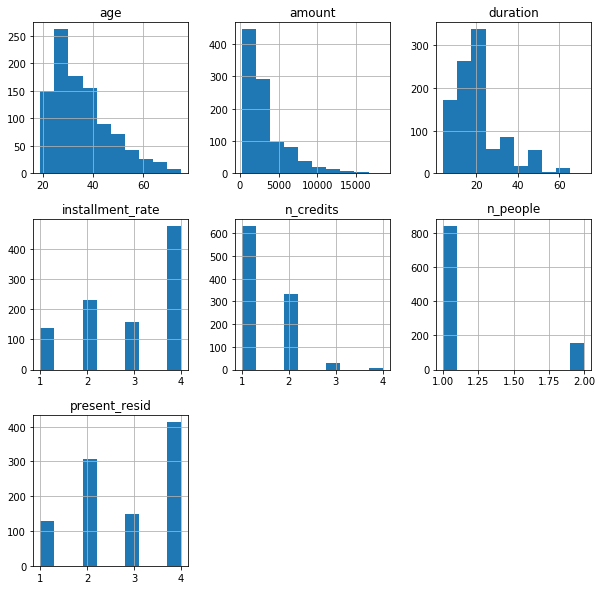

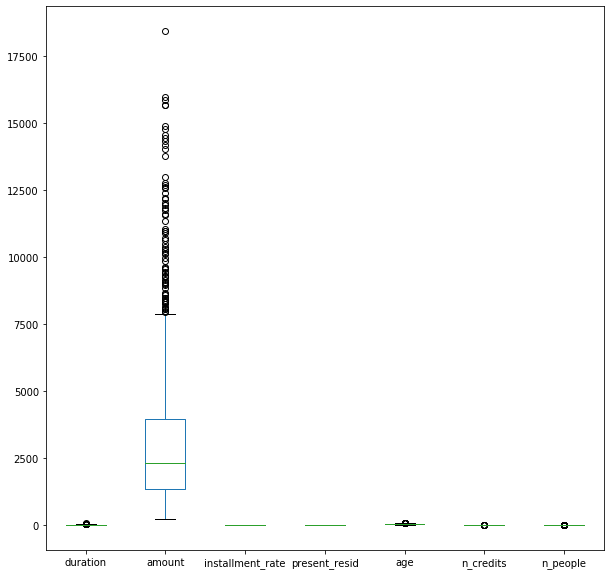

In [8]:
# fig, axes = plt.subplots (4,2, figsize=(10,10))
# cnt =len(german_credit_num.columns)
# i=0
# for i in range(cnt):
#     row = math.ceil(i / 2) 
#     col = math.ceil(i % 2)
#     col = (german_credit_num.iloc[:, i + 1])
    
german_credit_num.hist(figsize=(10,10)) ;
german_credit_num.plot.box(figsize = (10,10)) ;  
    

In [9]:
german_credit_num.loc[:,'duration']=np.log(german_credit_num.loc[:,'duration'])
german_credit_num.loc[:,'amount']=np.log(german_credit_num.loc[:,'amount'])
german_credit_num.loc[:, 'age']=np.log(german_credit_num.loc[:,'age'])

/usr/local/lib64/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


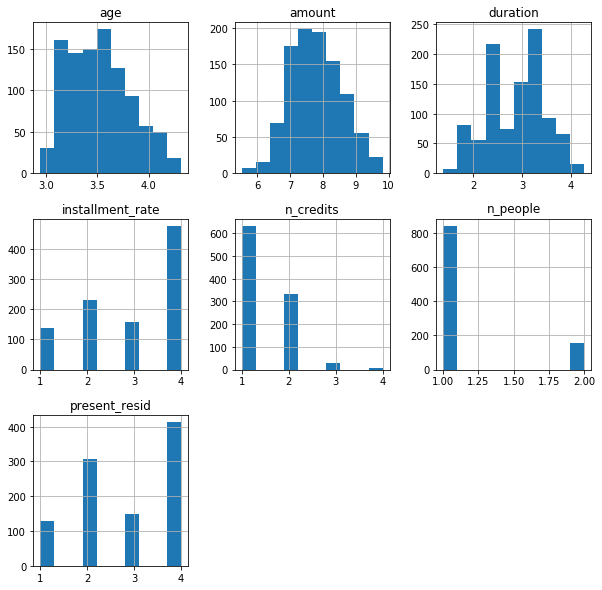

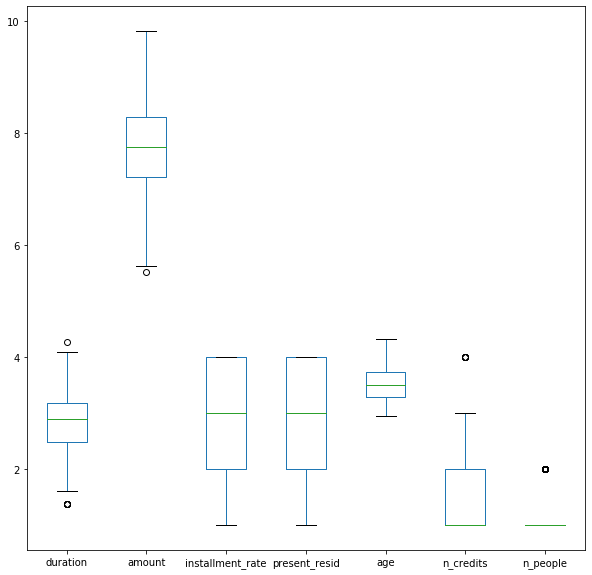

In [10]:
german_credit_num.hist(figsize=(10,10)) ;
german_credit_num.plot.box(figsize = (10,10)) ;  

In [11]:
#use standard scaler
scale =StandardScaler()
german_credit_num_std = scale.fit_transform(german_credit_num)
german_credit_num_std = pd.DataFrame(german_credit_num_std, columns = german_credit_num.columns)

In [12]:
german_credit_num_std.head()

,duration,amount,installment_rate,present_resid,age,n_credits,n_people
0,-1.864869,-0.933901,0.918477,1.046987,2.271006,1.027079,-0.428290
1,1.708369,1.163046,-0.870183,-0.765977,-1.446152,-0.704926,-0.428290
2,-0.673790,-0.181559,-0.870183,0.140505,1.226696,-0.704926,2.334869
3,1.478913,1.525148,-0.870183,1.046987,0.942455,-0.704926,2.334869
4,0.517289,0.904743,0.024147,1.046987,1.488620,1.027079,2.334869


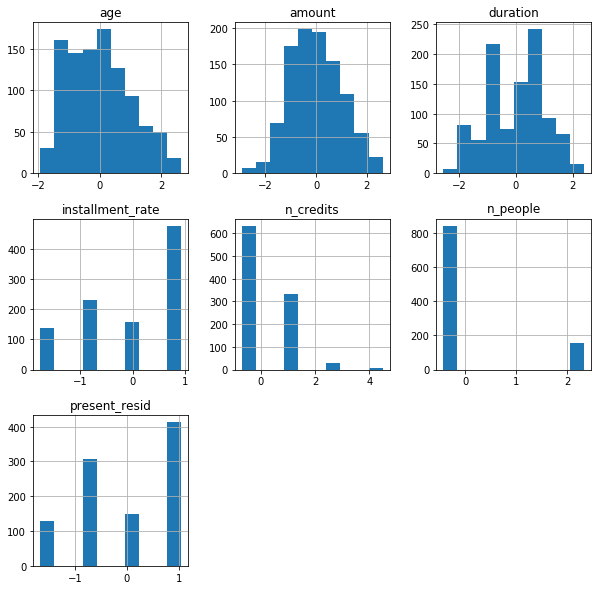

In [13]:
german_credit_num_std.hist(figsize=(10,10));

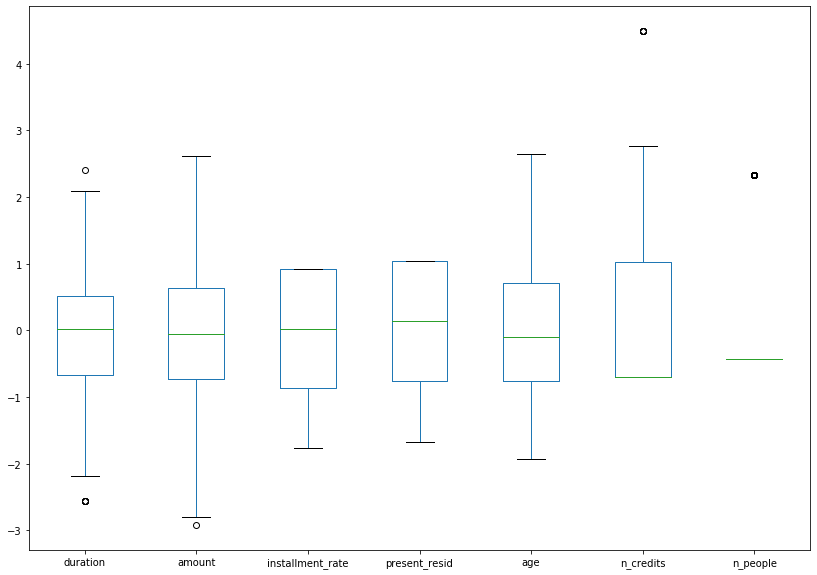

In [14]:
german_credit_num_std.plot.box(figsize=(14,10));

In [15]:
# german_credit_cat = german_credit_clean[['chk_acct','credit_his','sex','property','housing','present_emp']] 
german_credit_cat = pd.get_dummies(german_credit_clean[['chk_acct','credit_his','sex','property','housing','present_emp']] )

In [16]:
german_credit_clean = pd.concat([german_credit_num_std, german_credit_cat], axis = 1, join='inner')
german_credit_clean.shape

(1000, 32)

In [17]:
.head()

,duration,amount,installment_rate,present_resid,age,n_credits,n_people,chk_acct_A11,chk_acct_A12,chk_acct_A13,...,property_A123,property_A124,housing_A151,housing_A152,housing_A153,present_emp_A71,present_emp_A72,present_emp_A73,present_emp_A74,present_emp_A75
0,-1.864869,-0.933901,0.918477,1.046987,2.271006,1.027079,-0.428290,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1.708369,1.163046,-0.870183,-0.765977,-1.446152,-0.704926,-0.428290,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,-0.673790,-0.181559,-0.870183,0.140505,1.226696,-0.704926,2.334869,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1.478913,1.525148,-0.870183,1.046987,0.942455,-0.704926,2.334869,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.517289,0.904743,0.024147,1.046987,1.488620,1.027079,2.334869,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [18]:
arr = gower.gower_matrix(german_credit_clean)

In [20]:
arr.shape

(1000, 1000)

In [74]:
gower_idx = range(2,len(arr) +1)
gower_arr =np.array(list(zip(gower_idx, list(arr[0, 1:]))))

In [117]:
for i in range(2,11):
    clusterer = KPrototypes(n_clusters=i, init='Cao', verbose=2)
    cluster_labels = clusterer.fit_predict(german_credit_clean,categorical=list(range(7,32)))
    silhouette_avg = silhouette_score(german_credit_clean, cluster_labels)
    print("For n_clusters =", i,
      "The average silhouette_score is :", silhouette_avg)
    

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 136, ncost: 8702.327717570903
Run: 1, iteration: 2/100, moves: 77, ncost: 8640.891934548166
Run: 1, iteration: 3/100, moves: 34, ncost: 8627.41249954411
Run: 1, iteration: 4/100, moves: 14, ncost: 8625.05556918744
Run: 1, iteration: 5/100, moves: 8, ncost: 8624.094159592354
Run: 1, iteration: 6/100, moves: 12, ncost: 8622.827553142963
Run: 1, iteration: 7/100, moves: 4, ncost: 8622.402999186093
Run: 1, iteration: 8/100, moves: 4, ncost: 8622.135242788245
Run: 1, iteration: 9/100, moves: 1, ncost: 8622.098774852404
Run: 1, iteration: 10/100, moves: 0, ncost: 8622.098774852404
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 210, ncost: 8673.24860839265
Run: 2, iteration: 2/100, moves: 107, ncost: 8597.279884088397
Run: 2, iteration: 3/100, moves: 58, ncost: 8564.126363168814
Run: 2, iteration: 4/100, moves: 22, n

Run: 2, iteration: 7/100, moves: 0, ncost: 7827.9838087814405
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 210, ncost: 8043.29624649025
Run: 3, iteration: 2/100, moves: 103, ncost: 7971.9034446471605
Run: 3, iteration: 3/100, moves: 55, ncost: 7927.935996504756
Run: 3, iteration: 4/100, moves: 58, ncost: 7886.276798219641
Run: 3, iteration: 5/100, moves: 76, ncost: 7812.361214684584
Run: 3, iteration: 6/100, moves: 54, ncost: 7787.269674126618
Run: 3, iteration: 7/100, moves: 20, ncost: 7783.550690602725
Run: 3, iteration: 8/100, moves: 5, ncost: 7783.2353798577105
Run: 3, iteration: 9/100, moves: 2, ncost: 7783.154847399611
Run: 3, iteration: 10/100, moves: 0, ncost: 7783.154847399611
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 240, ncost: 7875.433797079402
Run: 4, iteration: 2/100, moves: 101, ncost: 7794.283387860268
Run: 4, iteration: 3/100, moves

Run: 5, iteration: 8/100, moves: 16, ncost: 7026.457971819385
Run: 5, iteration: 9/100, moves: 4, ncost: 7026.222954376129
Run: 5, iteration: 10/100, moves: 0, ncost: 7026.222954376129
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 315, ncost: 7708.075750677728
Run: 6, iteration: 2/100, moves: 150, ncost: 7579.978355966149
Run: 6, iteration: 3/100, moves: 124, ncost: 7461.776160999553
Run: 6, iteration: 4/100, moves: 97, ncost: 7405.677435589749
Run: 6, iteration: 5/100, moves: 31, ncost: 7397.446979817271
Run: 6, iteration: 6/100, moves: 16, ncost: 7394.424290621978
Run: 6, iteration: 7/100, moves: 11, ncost: 7392.11660936903
Run: 6, iteration: 8/100, moves: 10, ncost: 7390.167148467723
Run: 6, iteration: 9/100, moves: 5, ncost: 7389.601909970285
Run: 6, iteration: 10/100, moves: 0, ncost: 7389.601909970285
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 2

Run: 6, iteration: 5/100, moves: 12, ncost: 6702.264086241685
Run: 6, iteration: 6/100, moves: 6, ncost: 6701.727985080071
Run: 6, iteration: 7/100, moves: 9, ncost: 6698.451624827902
Run: 6, iteration: 8/100, moves: 4, ncost: 6698.337038663843
Run: 6, iteration: 9/100, moves: 0, ncost: 6698.337038663843
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 371, ncost: 6885.424036333557
Run: 7, iteration: 2/100, moves: 161, ncost: 6751.580437189559
Run: 7, iteration: 3/100, moves: 69, ncost: 6722.197610717352
Run: 7, iteration: 4/100, moves: 48, ncost: 6703.427244563761
Run: 7, iteration: 5/100, moves: 24, ncost: 6700.325280780526
Run: 7, iteration: 6/100, moves: 14, ncost: 6696.738290595745
Run: 7, iteration: 7/100, moves: 24, ncost: 6691.954833617856
Run: 7, iteration: 8/100, moves: 27, ncost: 6682.911264409641
Run: 7, iteration: 9/100, moves: 21, ncost: 6673.860806588353
Run: 7, iteration: 10/100, moves: 18, ncost: 6670.3624

Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 389, ncost: 6633.59099275584
Run: 7, iteration: 2/100, moves: 166, ncost: 6499.3226664868225
Run: 7, iteration: 3/100, moves: 88, ncost: 6441.380080768319
Run: 7, iteration: 4/100, moves: 42, ncost: 6431.810186865048
Run: 7, iteration: 5/100, moves: 14, ncost: 6429.7040419376535
Run: 7, iteration: 6/100, moves: 8, ncost: 6428.584601780992
Run: 7, iteration: 7/100, moves: 6, ncost: 6427.65991124935
Run: 7, iteration: 8/100, moves: 11, ncost: 6425.2725566013
Run: 7, iteration: 9/100, moves: 13, ncost: 6422.803151067039
Run: 7, iteration: 10/100, moves: 13, ncost: 6419.842940979043
Run: 7, iteration: 11/100, moves: 26, ncost: 6412.896618946972
Run: 7, iteration: 12/100, moves: 28, ncost: 6401.4625794978965
Run: 7, iteration: 13/100, moves: 26, ncost: 6393.3600309031435
Run: 7, iteration: 14/100, moves: 34, ncost: 6375.291302239081
Run: 7, iteration: 15/100, moves: 13, ncost: 6372.823246832494
Run: 7, itera

Run: 6, iteration: 19/100, moves: 13, ncost: 6118.93534838042
Run: 6, iteration: 20/100, moves: 15, ncost: 6115.570821291603
Run: 6, iteration: 21/100, moves: 16, ncost: 6111.801494659378
Run: 6, iteration: 22/100, moves: 13, ncost: 6109.740871610545
Run: 6, iteration: 23/100, moves: 5, ncost: 6108.205564368612
Run: 6, iteration: 24/100, moves: 15, ncost: 6101.830513506765
Run: 6, iteration: 25/100, moves: 21, ncost: 6090.254505070375
Run: 6, iteration: 26/100, moves: 14, ncost: 6086.130767203188
Run: 6, iteration: 27/100, moves: 12, ncost: 6083.242430129005
Run: 6, iteration: 28/100, moves: 10, ncost: 6080.570224253326
Run: 6, iteration: 29/100, moves: 7, ncost: 6079.599920567173
Run: 6, iteration: 30/100, moves: 3, ncost: 6079.247382299274
Run: 6, iteration: 31/100, moves: 2, ncost: 6078.969481690541
Run: 6, iteration: 32/100, moves: 3, ncost: 6078.49192163915
Run: 6, iteration: 33/100, moves: 1, ncost: 6078.423548035433
Run: 6, iteration: 34/100, moves: 0, ncost: 6078.423548035433
I

Run: 6, iteration: 7/100, moves: 23, ncost: 6037.931883794752
Run: 6, iteration: 8/100, moves: 14, ncost: 6033.569434410823
Run: 6, iteration: 9/100, moves: 29, ncost: 6019.245465215198
Run: 6, iteration: 10/100, moves: 28, ncost: 6007.387944633517
Run: 6, iteration: 11/100, moves: 26, ncost: 6001.063514928799
Run: 6, iteration: 12/100, moves: 23, ncost: 5983.827261911572
Run: 6, iteration: 13/100, moves: 22, ncost: 5974.6474875895765
Run: 6, iteration: 14/100, moves: 14, ncost: 5972.092197884578
Run: 6, iteration: 15/100, moves: 2, ncost: 5971.932986244423
Run: 6, iteration: 16/100, moves: 0, ncost: 5971.932986244423
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 329, ncost: 6081.965164261453
Run: 7, iteration: 2/100, moves: 102, ncost: 6030.807027679467
Run: 7, iteration: 3/100, moves: 54, ncost: 6001.257395037269
Run: 7, iteration: 4/100, moves: 43, ncost: 5984.843965588829
Run: 7, iteration: 5/100, moves: 37, ncost: 

Run: 5, iteration: 9/100, moves: 36, ncost: 5746.462038725981
Run: 5, iteration: 10/100, moves: 18, ncost: 5740.608881841405
Run: 5, iteration: 11/100, moves: 7, ncost: 5739.399402685286
Run: 5, iteration: 12/100, moves: 9, ncost: 5737.803289345188
Run: 5, iteration: 13/100, moves: 8, ncost: 5736.152236866911
Run: 5, iteration: 14/100, moves: 3, ncost: 5735.830220569927
Run: 5, iteration: 15/100, moves: 2, ncost: 5735.529649310055
Run: 5, iteration: 16/100, moves: 1, ncost: 5735.496949750426
Run: 5, iteration: 17/100, moves: 0, ncost: 5735.496949750426
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 364, ncost: 6054.491891868565
Run: 6, iteration: 2/100, moves: 142, ncost: 5914.621862204901
Run: 6, iteration: 3/100, moves: 101, ncost: 5831.333800481342
Run: 6, iteration: 4/100, moves: 74, ncost: 5778.63135091108
Run: 6, iteration: 5/100, moves: 54, ncost: 5750.7560576334845
Run: 6, iteration: 6/100, moves: 23, ncost: 5743

Run: 4, iteration: 4/100, moves: 49, ncost: 5675.326869630923
Run: 4, iteration: 5/100, moves: 42, ncost: 5656.350033883862
Run: 4, iteration: 6/100, moves: 25, ncost: 5650.619213510107
Run: 4, iteration: 7/100, moves: 15, ncost: 5640.010472668025
Run: 4, iteration: 8/100, moves: 32, ncost: 5628.333804011928
Run: 4, iteration: 9/100, moves: 15, ncost: 5625.792988808682
Run: 4, iteration: 10/100, moves: 3, ncost: 5625.394604196756
Run: 4, iteration: 11/100, moves: 3, ncost: 5624.994546973976
Run: 4, iteration: 12/100, moves: 4, ncost: 5624.499454293015
Run: 4, iteration: 13/100, moves: 1, ncost: 5624.2969917228775
Run: 4, iteration: 14/100, moves: 0, ncost: 5624.2969917228775
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 438, ncost: 5785.050510420428
Run: 5, iteration: 2/100, moves: 120, ncost: 5708.492348434684
Run: 5, iteration: 3/100, moves: 33, ncost: 5700.958855316069
Run: 5, iteration: 4/100, moves: 8, ncost: 5699.

In [118]:
%%time
cost=[]
for i in range(2,11):
    clusterer = KPrototypes(n_clusters=i, init='Cao', verbose=2)
    cluster_labels = clusterer.fit_predict(german_credit_clean,categorical=list(range(7,32)))
    cost.append(clusterer.cost_)
    


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 213, ncost: 8614.67777613169
Run: 1, iteration: 2/100, moves: 99, ncost: 8560.01454793401
Run: 1, iteration: 3/100, moves: 21, ncost: 8556.112070040044
Run: 1, iteration: 4/100, moves: 3, ncost: 8556.023068832537
Run: 1, iteration: 5/100, moves: 0, ncost: 8556.023068832537
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 211, ncost: 8695.527167679278
Run: 2, iteration: 2/100, moves: 105, ncost: 8612.185415369595
Run: 2, iteration: 3/100, moves: 66, ncost: 8568.565737426774
Run: 2, iteration: 4/100, moves: 39, ncost: 8561.278994290618
Run: 2, iteration: 5/100, moves: 19, ncost: 8558.107231047397
Run: 2, iteration: 6/100, moves: 9, ncost: 8557.302884472618
Run: 2, iteration: 7/100, moves: 4, ncost: 8556.895927660977
Run: 2, iteration: 8/100, moves: 7, ncost: 8556.362649406869
Run: 2, iteration: 9/100, moves: 0, nc

Run: 5, iteration: 3/100, moves: 75, ncost: 7808.804005004619
Run: 5, iteration: 4/100, moves: 44, ncost: 7794.522572848432
Run: 5, iteration: 5/100, moves: 25, ncost: 7791.153431757866
Run: 5, iteration: 6/100, moves: 13, ncost: 7789.801697162757
Run: 5, iteration: 7/100, moves: 12, ncost: 7788.4301210171725
Run: 5, iteration: 8/100, moves: 5, ncost: 7787.930588381086
Run: 5, iteration: 9/100, moves: 6, ncost: 7787.627385937147
Run: 5, iteration: 10/100, moves: 0, ncost: 7787.627385937147
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 282, ncost: 8064.828509238898
Run: 6, iteration: 2/100, moves: 114, ncost: 7968.955955301082
Run: 6, iteration: 3/100, moves: 62, ncost: 7946.803376851828
Run: 6, iteration: 4/100, moves: 22, ncost: 7943.6514927616245
Run: 6, iteration: 5/100, moves: 12, ncost: 7942.488772078857
Run: 6, iteration: 6/100, moves: 2, ncost: 7942.342034720821
Run: 6, iteration: 7/100, moves: 1, ncost: 7942.303

Run: 6, iteration: 13/100, moves: 15, ncost: 7401.88815767515
Run: 6, iteration: 14/100, moves: 15, ncost: 7398.844057957159
Run: 6, iteration: 15/100, moves: 12, ncost: 7397.0469043363355
Run: 6, iteration: 16/100, moves: 9, ncost: 7395.710297886724
Run: 6, iteration: 17/100, moves: 13, ncost: 7394.105755748418
Run: 6, iteration: 18/100, moves: 4, ncost: 7393.916268449923
Run: 6, iteration: 19/100, moves: 0, ncost: 7393.916268449923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 319, ncost: 7597.489976127455
Run: 7, iteration: 2/100, moves: 181, ncost: 7325.691853027924
Run: 7, iteration: 3/100, moves: 64, ncost: 7295.348619952775
Run: 7, iteration: 4/100, moves: 11, ncost: 7293.956304049447
Run: 7, iteration: 5/100, moves: 10, ncost: 7292.5514058119215
Run: 7, iteration: 6/100, moves: 16, ncost: 7289.0553781061935
Run: 7, iteration: 7/100, moves: 17, ncost: 7285.504527291016
Run: 7, iteration: 8/100, moves: 10, ncost: 

Run: 5, iteration: 22/100, moves: 4, ncost: 6669.906764216759
Run: 5, iteration: 23/100, moves: 2, ncost: 6669.827212191703
Run: 5, iteration: 24/100, moves: 0, ncost: 6669.827212191703
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 336, ncost: 6775.413435303466
Run: 6, iteration: 2/100, moves: 119, ncost: 6689.592885463375
Run: 6, iteration: 3/100, moves: 52, ncost: 6670.847150552501
Run: 6, iteration: 4/100, moves: 18, ncost: 6667.669487905201
Run: 6, iteration: 5/100, moves: 19, ncost: 6658.543445388049
Run: 6, iteration: 6/100, moves: 27, ncost: 6651.221177515335
Run: 6, iteration: 7/100, moves: 13, ncost: 6647.932384090417
Run: 6, iteration: 8/100, moves: 9, ncost: 6647.074386249779
Run: 6, iteration: 9/100, moves: 5, ncost: 6646.319012389781
Run: 6, iteration: 10/100, moves: 4, ncost: 6645.913543712965
Run: 6, iteration: 11/100, moves: 0, ncost: 6645.913543712965
Init: initializing centroids
Init: initializing clus

Run: 5, iteration: 7/100, moves: 0, ncost: 6406.398938503538
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 323, ncost: 6554.490087302463
Run: 6, iteration: 2/100, moves: 117, ncost: 6470.922875653472
Run: 6, iteration: 3/100, moves: 62, ncost: 6447.710033912691
Run: 6, iteration: 4/100, moves: 13, ncost: 6446.039444615529
Run: 6, iteration: 5/100, moves: 8, ncost: 6444.574415570296
Run: 6, iteration: 6/100, moves: 17, ncost: 6439.2505491311695
Run: 6, iteration: 7/100, moves: 14, ncost: 6435.7340843764805
Run: 6, iteration: 8/100, moves: 7, ncost: 6434.802421320949
Run: 6, iteration: 9/100, moves: 1, ncost: 6434.678783726623
Run: 6, iteration: 10/100, moves: 1, ncost: 6434.648631708659
Run: 6, iteration: 11/100, moves: 0, ncost: 6434.648631708659
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 355, ncost: 6694.163805375269
Run: 7, iteration: 2/100, moves: 

Run: 6, iteration: 3/100, moves: 56, ncost: 6199.151216230998
Run: 6, iteration: 4/100, moves: 36, ncost: 6185.723271286203
Run: 6, iteration: 5/100, moves: 27, ncost: 6177.563261966406
Run: 6, iteration: 6/100, moves: 19, ncost: 6170.616723377941
Run: 6, iteration: 7/100, moves: 19, ncost: 6167.198585739892
Run: 6, iteration: 8/100, moves: 2, ncost: 6167.053730998705
Run: 6, iteration: 9/100, moves: 1, ncost: 6167.021167488392
Run: 6, iteration: 10/100, moves: 0, ncost: 6167.021167488392
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 370, ncost: 6475.082455124287
Run: 7, iteration: 2/100, moves: 178, ncost: 6280.571450714687
Run: 7, iteration: 3/100, moves: 82, ncost: 6228.682720095307
Run: 7, iteration: 4/100, moves: 43, ncost: 6217.471087762114
Run: 7, iteration: 5/100, moves: 31, ncost: 6207.974977321733
Run: 7, iteration: 6/100, moves: 22, ncost: 6205.06047142561
Run: 7, iteration: 7/100, moves: 24, ncost: 6198.4433

Run: 5, iteration: 1/100, moves: 368, ncost: 6119.343425450601
Run: 5, iteration: 2/100, moves: 124, ncost: 6039.596052122114
Run: 5, iteration: 3/100, moves: 61, ncost: 5997.611164777909
Run: 5, iteration: 4/100, moves: 23, ncost: 5992.267776324419
Run: 5, iteration: 5/100, moves: 22, ncost: 5984.287459497871
Run: 5, iteration: 6/100, moves: 37, ncost: 5962.548710921138
Run: 5, iteration: 7/100, moves: 38, ncost: 5941.478621858237
Run: 5, iteration: 8/100, moves: 32, ncost: 5926.235090819466
Run: 5, iteration: 9/100, moves: 35, ncost: 5902.332218944332
Run: 5, iteration: 10/100, moves: 22, ncost: 5896.556090488331
Run: 5, iteration: 11/100, moves: 7, ncost: 5895.072446870143
Run: 5, iteration: 12/100, moves: 13, ncost: 5889.3793991810135
Run: 5, iteration: 13/100, moves: 8, ncost: 5888.524369991422
Run: 5, iteration: 14/100, moves: 0, ncost: 5888.524369991422
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 360, ncost: 61

Run: 4, iteration: 20/100, moves: 0, ncost: 5711.751856821032
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 405, ncost: 6009.938607659096
Run: 5, iteration: 2/100, moves: 154, ncost: 5866.565968168008
Run: 5, iteration: 3/100, moves: 68, ncost: 5823.5945406075925
Run: 5, iteration: 4/100, moves: 38, ncost: 5803.164965838575
Run: 5, iteration: 5/100, moves: 32, ncost: 5791.295026343935
Run: 5, iteration: 6/100, moves: 17, ncost: 5787.087981289766
Run: 5, iteration: 7/100, moves: 13, ncost: 5784.120400278015
Run: 5, iteration: 8/100, moves: 15, ncost: 5778.488655948626
Run: 5, iteration: 9/100, moves: 25, ncost: 5769.957824043705
Run: 5, iteration: 10/100, moves: 19, ncost: 5766.353149217804
Run: 5, iteration: 11/100, moves: 3, ncost: 5766.055232598154
Run: 5, iteration: 12/100, moves: 0, ncost: 5766.055232598154
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, move

Run: 5, iteration: 7/100, moves: 6, ncost: 5620.193048688435
Run: 5, iteration: 8/100, moves: 11, ncost: 5615.634101197636
Run: 5, iteration: 9/100, moves: 8, ncost: 5613.439144237972
Run: 5, iteration: 10/100, moves: 3, ncost: 5612.364800037848
Run: 5, iteration: 11/100, moves: 1, ncost: 5611.7120860847745
Run: 5, iteration: 12/100, moves: 0, ncost: 5611.7120860847745
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 440, ncost: 5796.829370295127
Run: 6, iteration: 2/100, moves: 186, ncost: 5653.299318402111
Run: 6, iteration: 3/100, moves: 82, ncost: 5597.789942706528
Run: 6, iteration: 4/100, moves: 56, ncost: 5567.669099488375
Run: 6, iteration: 5/100, moves: 35, ncost: 5553.370629227605
Run: 6, iteration: 6/100, moves: 12, ncost: 5550.636657966317
Run: 6, iteration: 7/100, moves: 6, ncost: 5549.956685644943
Run: 6, iteration: 8/100, moves: 0, ncost: 5549.956685644943
Init: initializing centroids
Init: initializing clus

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


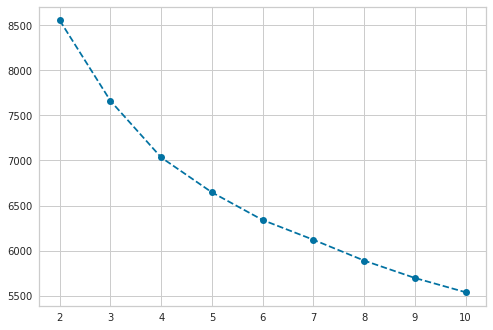

In [130]:
t = dict({'clusterCount': list(range(2,11)), 'cost': cost})
df = pd.DataFrame.from_dict(t)
plt.plot(df['clusterCount'], df['cost'], linestyle='--', marker='o', color='b');

In [131]:
%%time
for i in range(11,15):
    clusterer = KPrototypes(n_clusters=i, init='Cao', verbose=2)
    cluster_labels = clusterer.fit_predict(german_credit_clean,categorical=list(range(7,32)))
    cost.append(clusterer.cost_)
    

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 452, ncost: 5880.023393513961
Run: 1, iteration: 2/100, moves: 206, ncost: 5645.042974501718
Run: 1, iteration: 3/100, moves: 116, ncost: 5513.474047383652
Run: 1, iteration: 4/100, moves: 44, ncost: 5496.815088291166
Run: 1, iteration: 5/100, moves: 17, ncost: 5492.828361640513
Run: 1, iteration: 6/100, moves: 4, ncost: 5492.053736746685
Run: 1, iteration: 7/100, moves: 6, ncost: 5490.133586622867
Run: 1, iteration: 8/100, moves: 7, ncost: 5488.4286695899555
Run: 1, iteration: 9/100, moves: 0, ncost: 5488.4286695899555
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 354, ncost: 5542.039438750096
Run: 2, iteration: 2/100, moves: 118, ncost: 5450.318242840027
Run: 2, iteration: 3/100, moves: 45, ncost: 5432.590945679404
Run: 2, iteration: 4/100, moves: 19, ncost: 5427.607016251163
Run: 2, iteration: 5/100, moves

Run: 2, iteration: 8/100, moves: 8, ncost: 5499.788827903332
Run: 2, iteration: 9/100, moves: 2, ncost: 5499.660915316789
Run: 2, iteration: 10/100, moves: 2, ncost: 5499.57687844249
Run: 2, iteration: 11/100, moves: 0, ncost: 5499.57687844249
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 336, ncost: 5515.623888235554
Run: 3, iteration: 2/100, moves: 124, ncost: 5397.013872087644
Run: 3, iteration: 3/100, moves: 78, ncost: 5351.9762401650805
Run: 3, iteration: 4/100, moves: 49, ncost: 5330.76252227606
Run: 3, iteration: 5/100, moves: 48, ncost: 5308.449869630139
Run: 3, iteration: 6/100, moves: 21, ncost: 5300.287638134
Run: 3, iteration: 7/100, moves: 36, ncost: 5281.074405385761
Run: 3, iteration: 8/100, moves: 46, ncost: 5259.143579425798
Run: 3, iteration: 9/100, moves: 29, ncost: 5244.468366214966
Run: 3, iteration: 10/100, moves: 20, ncost: 5238.288167344922
Run: 3, iteration: 11/100, moves: 10, ncost: 5235.067069

Run: 1, iteration: 7/100, moves: 30, ncost: 5175.86437332181
Run: 1, iteration: 8/100, moves: 25, ncost: 5168.606717646124
Run: 1, iteration: 9/100, moves: 13, ncost: 5161.334384878932
Run: 1, iteration: 10/100, moves: 11, ncost: 5158.427347832733
Run: 1, iteration: 11/100, moves: 5, ncost: 5157.889427874287
Run: 1, iteration: 12/100, moves: 3, ncost: 5157.375692183509
Run: 1, iteration: 13/100, moves: 5, ncost: 5156.184339835811
Run: 1, iteration: 14/100, moves: 2, ncost: 5155.910495773239
Run: 1, iteration: 15/100, moves: 1, ncost: 5155.793960632062
Run: 1, iteration: 16/100, moves: 3, ncost: 5155.327246659381
Run: 1, iteration: 17/100, moves: 1, ncost: 5155.2555355001905
Run: 1, iteration: 18/100, moves: 0, ncost: 5155.2555355001905
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 400, ncost: 5447.786871345032
Run: 2, iteration: 2/100, moves: 200, ncost: 5254.876172413927
Run: 2, iteration: 3/100, moves: 67, ncost: 5232

Run: 10, iteration: 19/100, moves: 4, ncost: 5279.820178091028
Run: 10, iteration: 20/100, moves: 2, ncost: 5279.667966234406
Run: 10, iteration: 21/100, moves: 1, ncost: 5279.593869662954
Run: 10, iteration: 22/100, moves: 0, ncost: 5279.593869662954
Best run was number 9
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 426, ncost: 5469.580913150393
Run: 1, iteration: 2/100, moves: 188, ncost: 5308.948325646287
Run: 1, iteration: 3/100, moves: 106, ncost: 5228.130336964755
Run: 1, iteration: 4/100, moves: 73, ncost: 5152.927011918495
Run: 1, iteration: 5/100, moves: 36, ncost: 5142.318739226197
Run: 1, iteration: 6/100, moves: 20, ncost: 5136.316054722434
Run: 1, iteration: 7/100, moves: 23, ncost: 5126.447422188019
Run: 1, iteration: 8/100, moves: 21, ncost: 5117.806557554261
Run: 1, iteration: 9/100, moves: 9, ncost: 5116.411069647068
Run: 1, iteration: 10/100, mo

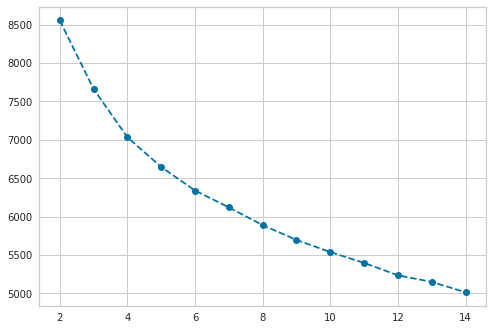

In [132]:
t = dict({'clusterCount': list(range(2,15)), 'cost': cost})
df = pd.DataFrame.from_dict(t)
plt.plot(df['clusterCount'], df['cost'], linestyle='--', marker='o', color='b');

In [135]:
%%time
cost_huang=[]
for i in range(2,15):
    clusterer = KPrototypes(n_clusters=i, init='Huang', verbose=2)
    cluster_labels = clusterer.fit_predict(german_credit_clean,categorical=list(range(7,32)))
    cost_huang.append(clusterer.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 143, ncost: 8701.786816809656
Run: 1, iteration: 2/100, moves: 51, ncost: 8687.708973936342
Run: 1, iteration: 3/100, moves: 16, ncost: 8684.647929909042
Run: 1, iteration: 4/100, moves: 17, ncost: 8679.604957293252
Run: 1, iteration: 5/100, moves: 29, ncost: 8668.049334751626
Run: 1, iteration: 6/100, moves: 38, ncost: 8651.262169062486
Run: 1, iteration: 7/100, moves: 38, ncost: 8636.328222406431
Run: 1, iteration: 8/100, moves: 56, ncost: 8592.295638613832
Run: 1, iteration: 9/100, moves: 42, ncost: 8577.312202480573
Run: 1, iteration: 10/100, moves: 22, ncost: 8569.964104606272
Run: 1, iteration: 11/100, moves: 24, ncost: 8563.333900232888
Run: 1, iteration: 12/100, moves: 18, ncost: 8558.733061151761
Run: 1, iteration: 13/100, moves: 13, ncost: 8556.193624266905
Run: 1, iteration: 14/100, moves: 8, ncost: 8555.623106406332
Run: 1, iteration: 15/100, moves: 7, ncost: 855

Run: 2, iteration: 5/100, moves: 40, ncost: 7835.424693918164
Run: 2, iteration: 6/100, moves: 25, ncost: 7829.7436875061385
Run: 2, iteration: 7/100, moves: 25, ncost: 7824.973298360369
Run: 2, iteration: 8/100, moves: 11, ncost: 7823.369575781085
Run: 2, iteration: 9/100, moves: 8, ncost: 7822.202317547292
Run: 2, iteration: 10/100, moves: 5, ncost: 7821.955292881528
Run: 2, iteration: 11/100, moves: 0, ncost: 7821.955292881528
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 191, ncost: 8049.6563259767545
Run: 3, iteration: 2/100, moves: 79, ncost: 8011.818915885146
Run: 3, iteration: 3/100, moves: 56, ncost: 7984.223970761891
Run: 3, iteration: 4/100, moves: 61, ncost: 7944.37345086833
Run: 3, iteration: 5/100, moves: 83, ncost: 7882.169540516666
Run: 3, iteration: 6/100, moves: 77, ncost: 7842.115752928469
Run: 3, iteration: 7/100, moves: 49, ncost: 7816.550307782361
Run: 3, iteration: 8/100, moves: 26, ncost: 7809.03

Run: 3, iteration: 6/100, moves: 46, ncost: 7038.380973883998
Run: 3, iteration: 7/100, moves: 21, ncost: 7033.89450937743
Run: 3, iteration: 8/100, moves: 7, ncost: 7033.40777392059
Run: 3, iteration: 9/100, moves: 1, ncost: 7033.342912712232
Run: 3, iteration: 10/100, moves: 0, ncost: 7033.342912712232
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 312, ncost: 7583.670327794092
Run: 4, iteration: 2/100, moves: 150, ncost: 7453.9426264404065
Run: 4, iteration: 3/100, moves: 101, ncost: 7374.860503312847
Run: 4, iteration: 4/100, moves: 45, ncost: 7360.717743587464
Run: 4, iteration: 5/100, moves: 26, ncost: 7355.201592326601
Run: 4, iteration: 6/100, moves: 27, ncost: 7349.116609914904
Run: 4, iteration: 7/100, moves: 9, ncost: 7348.107494376342
Run: 4, iteration: 8/100, moves: 8, ncost: 7347.37895680703
Run: 4, iteration: 9/100, moves: 1, ncost: 7347.335211036622
Run: 4, iteration: 10/100, moves: 2, ncost: 7347.2464471

Run: 1, iteration: 19/100, moves: 0, ncost: 6750.674922097338
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 259, ncost: 7259.580058380223
Run: 2, iteration: 2/100, moves: 157, ncost: 7132.659047801943
Run: 2, iteration: 3/100, moves: 86, ncost: 7081.162268734379
Run: 2, iteration: 4/100, moves: 78, ncost: 7032.8690822097815
Run: 2, iteration: 5/100, moves: 47, ncost: 7019.509374190809
Run: 2, iteration: 6/100, moves: 30, ncost: 7011.545389772743
Run: 2, iteration: 7/100, moves: 30, ncost: 7001.543558558633
Run: 2, iteration: 8/100, moves: 33, ncost: 6990.760774127398
Run: 2, iteration: 9/100, moves: 14, ncost: 6989.5634042932525
Run: 2, iteration: 10/100, moves: 5, ncost: 6989.091220557812
Run: 2, iteration: 11/100, moves: 2, ncost: 6988.869125676513
Run: 2, iteration: 12/100, moves: 2, ncost: 6988.768116376234
Run: 2, iteration: 13/100, moves: 0, ncost: 6988.768116376234
Init: initializing centroids
Init: initializing 

Run: 2, iteration: 11/100, moves: 18, ncost: 6382.338966105565
Run: 2, iteration: 12/100, moves: 8, ncost: 6381.240475769273
Run: 2, iteration: 13/100, moves: 6, ncost: 6380.149754156922
Run: 2, iteration: 14/100, moves: 3, ncost: 6379.699520286179
Run: 2, iteration: 15/100, moves: 1, ncost: 6379.609484105591
Run: 2, iteration: 16/100, moves: 0, ncost: 6379.609484105591
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 254, ncost: 6755.979268735745
Run: 3, iteration: 2/100, moves: 125, ncost: 6631.632715793914
Run: 3, iteration: 3/100, moves: 93, ncost: 6556.130304945183
Run: 3, iteration: 4/100, moves: 100, ncost: 6478.699471385444
Run: 3, iteration: 5/100, moves: 56, ncost: 6450.968993304258
Run: 3, iteration: 6/100, moves: 42, ncost: 6435.464407122278
Run: 3, iteration: 7/100, moves: 19, ncost: 6431.966192254606
Run: 3, iteration: 8/100, moves: 28, ncost: 6423.367315932168
Run: 3, iteration: 9/100, moves: 13, ncost: 6419

Starting iterations...
Run: 2, iteration: 1/100, moves: 472, ncost: 6315.757857213992
Run: 2, iteration: 2/100, moves: 112, ncost: 6259.083951111034
Run: 2, iteration: 3/100, moves: 34, ncost: 6250.603259452026
Run: 2, iteration: 4/100, moves: 14, ncost: 6247.684269126067
Run: 2, iteration: 5/100, moves: 11, ncost: 6246.79249542623
Run: 2, iteration: 6/100, moves: 2, ncost: 6246.699682234748
Run: 2, iteration: 7/100, moves: 0, ncost: 6246.699682234748
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 409, ncost: 6360.616521934149
Run: 3, iteration: 2/100, moves: 147, ncost: 6239.361179544769
Run: 3, iteration: 3/100, moves: 53, ncost: 6216.319220704112
Run: 3, iteration: 4/100, moves: 23, ncost: 6211.837513917598
Run: 3, iteration: 5/100, moves: 11, ncost: 6209.731387977702
Run: 3, iteration: 6/100, moves: 16, ncost: 6205.889298453867
Run: 3, iteration: 7/100, moves: 18, ncost: 6197.078056975554
Run: 3, iteration: 8/100, mo

Run: 10, iteration: 5/100, moves: 30, ncost: 6287.6306583539035
Run: 10, iteration: 6/100, moves: 20, ncost: 6278.743685433728
Run: 10, iteration: 7/100, moves: 30, ncost: 6266.660050568685
Run: 10, iteration: 8/100, moves: 33, ncost: 6256.98205058704
Run: 10, iteration: 9/100, moves: 28, ncost: 6250.252251705775
Run: 10, iteration: 10/100, moves: 34, ncost: 6233.264218916816
Run: 10, iteration: 11/100, moves: 18, ncost: 6229.664954365359
Run: 10, iteration: 12/100, moves: 11, ncost: 6225.414936154312
Run: 10, iteration: 13/100, moves: 22, ncost: 6218.064688530172
Run: 10, iteration: 14/100, moves: 14, ncost: 6215.265166634287
Run: 10, iteration: 15/100, moves: 6, ncost: 6212.105748511112
Run: 10, iteration: 16/100, moves: 19, ncost: 6206.171557571065
Run: 10, iteration: 17/100, moves: 20, ncost: 6199.275998933557
Run: 10, iteration: 18/100, moves: 16, ncost: 6195.102799865511
Run: 10, iteration: 19/100, moves: 17, ncost: 6189.055829516069
Run: 10, iteration: 20/100, moves: 11, ncost: 

Starting iterations...
Run: 10, iteration: 1/100, moves: 409, ncost: 6120.476237266415
Run: 10, iteration: 2/100, moves: 131, ncost: 6013.997691863617
Run: 10, iteration: 3/100, moves: 79, ncost: 5955.669470331282
Run: 10, iteration: 4/100, moves: 50, ncost: 5929.5081365560045
Run: 10, iteration: 5/100, moves: 31, ncost: 5911.949848048107
Run: 10, iteration: 6/100, moves: 20, ncost: 5905.34172185497
Run: 10, iteration: 7/100, moves: 8, ncost: 5903.393422861377
Run: 10, iteration: 8/100, moves: 9, ncost: 5901.231767712454
Run: 10, iteration: 9/100, moves: 3, ncost: 5901.06226371377
Run: 10, iteration: 10/100, moves: 0, ncost: 5901.06226371377
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 403, ncost: 6050.27831532834
Run: 1, iteration: 2/100, moves: 123, ncost: 5967.206020350016
Run: 1, iteration: 3/100, moves: 106, ncost: 5889.076774387626
Run: 1, iteration: 4/100, moves: 52, ncost: 5872.03745761605

Run: 10, iteration: 3/100, moves: 62, ncost: 5766.3795312261
Run: 10, iteration: 4/100, moves: 20, ncost: 5760.453984872418
Run: 10, iteration: 5/100, moves: 20, ncost: 5747.973551163435
Run: 10, iteration: 6/100, moves: 32, ncost: 5733.135495039905
Run: 10, iteration: 7/100, moves: 14, ncost: 5729.6325998873535
Run: 10, iteration: 8/100, moves: 10, ncost: 5726.864535809513
Run: 10, iteration: 9/100, moves: 9, ncost: 5725.7052788016745
Run: 10, iteration: 10/100, moves: 3, ncost: 5725.285008686852
Run: 10, iteration: 11/100, moves: 0, ncost: 5725.285008686852
Best run was number 6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 390, ncost: 5774.240885508185
Run: 1, iteration: 2/100, moves: 146, ncost: 5654.3311421806975
Run: 1, iteration: 3/100, moves: 60, ncost: 5619.792342315313
Run: 1, iteration: 4/100, moves: 18, ncost: 5614.6930682571565
Run: 1, iteration: 5/100, moves: 8, ncost: 5611.118426093079
Run: 1, iteration: 

Run: 9, iteration: 1/100, moves: 417, ncost: 5886.225478642561
Run: 9, iteration: 2/100, moves: 141, ncost: 5764.413450556242
Run: 9, iteration: 3/100, moves: 67, ncost: 5737.0608338332895
Run: 9, iteration: 4/100, moves: 37, ncost: 5722.72802092614
Run: 9, iteration: 5/100, moves: 47, ncost: 5697.633879702855
Run: 9, iteration: 6/100, moves: 78, ncost: 5648.739033685061
Run: 9, iteration: 7/100, moves: 40, ncost: 5636.72167832416
Run: 9, iteration: 8/100, moves: 14, ncost: 5632.272639635839
Run: 9, iteration: 9/100, moves: 5, ncost: 5630.889580092513
Run: 9, iteration: 10/100, moves: 1, ncost: 5630.829713902528
Run: 9, iteration: 11/100, moves: 0, ncost: 5630.829713902528
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 401, ncost: 5866.170539382466
Run: 10, iteration: 2/100, moves: 181, ncost: 5713.654831821752
Run: 10, iteration: 3/100, moves: 97, ncost: 5659.753025403217
Run: 10, iteration: 4/100, moves: 39, ncost: 56

Run: 8, iteration: 10/100, moves: 2, ncost: 5451.03355835269
Run: 8, iteration: 11/100, moves: 3, ncost: 5450.489902862049
Run: 8, iteration: 12/100, moves: 4, ncost: 5449.440824915034
Run: 8, iteration: 13/100, moves: 0, ncost: 5449.440824915034
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 419, ncost: 5735.169132196522
Run: 9, iteration: 2/100, moves: 189, ncost: 5583.122111562822
Run: 9, iteration: 3/100, moves: 76, ncost: 5534.459858231877
Run: 9, iteration: 4/100, moves: 64, ncost: 5474.401614433303
Run: 9, iteration: 5/100, moves: 49, ncost: 5435.634129802794
Run: 9, iteration: 6/100, moves: 23, ncost: 5428.317762499659
Run: 9, iteration: 7/100, moves: 7, ncost: 5426.774176426045
Run: 9, iteration: 8/100, moves: 7, ncost: 5424.251224517119
Run: 9, iteration: 9/100, moves: 12, ncost: 5421.966278952322
Run: 9, iteration: 10/100, moves: 2, ncost: 5421.815543568

Run: 8, iteration: 2/100, moves: 154, ncost: 5465.059594033698
Run: 8, iteration: 3/100, moves: 110, ncost: 5361.267098113701
Run: 8, iteration: 4/100, moves: 77, ncost: 5314.040446280008
Run: 8, iteration: 5/100, moves: 45, ncost: 5293.546105961112
Run: 8, iteration: 6/100, moves: 25, ncost: 5284.173599410648
Run: 8, iteration: 7/100, moves: 23, ncost: 5273.292923812477
Run: 8, iteration: 8/100, moves: 14, ncost: 5263.559149389885
Run: 8, iteration: 9/100, moves: 6, ncost: 5261.279072300424
Run: 8, iteration: 10/100, moves: 8, ncost: 5259.0362560063495
Run: 8, iteration: 11/100, moves: 1, ncost: 5258.798578464464
Run: 8, iteration: 12/100, moves: 0, ncost: 5258.798578464464
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 422, ncost: 5529.569872382551
Run: 9, iteration: 2/100, moves: 142, ncost: 5421.316847986044
Run: 9, iteration: 3/100, moves: 67, ncost: 5388.09755305202
Run: 9, iteration: 4/100, moves: 30, ncost: 5370.

Run: 8, iteration: 8/100, moves: 2, ncost: 5189.705114841823
Run: 8, iteration: 9/100, moves: 1, ncost: 5189.592697718059
Run: 8, iteration: 10/100, moves: 0, ncost: 5189.592697718059
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 433, ncost: 5454.985570125209
Run: 9, iteration: 2/100, moves: 176, ncost: 5268.26186388674
Run: 9, iteration: 3/100, moves: 84, ncost: 5221.427242182137
Run: 9, iteration: 4/100, moves: 48, ncost: 5204.067191055863
Run: 9, iteration: 5/100, moves: 14, ncost: 5201.845274652462
Run: 9, iteration: 6/100, moves: 3, ncost: 5201.2114642416955
Run: 9, iteration: 7/100, moves: 11, ncost: 5197.8538331297705
Run: 9, iteration: 8/100, moves: 3, ncost: 5196.543063763748
Run: 9, iteration: 9/100, moves: 2, ncost: 5196.409621363985
Run: 9, iteration: 10/100, moves: 0, ncost: 5196.409621363985
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 32

Run: 8, iteration: 4/100, moves: 34, ncost: 5047.037511797645
Run: 8, iteration: 5/100, moves: 12, ncost: 5041.870662131348
Run: 8, iteration: 6/100, moves: 7, ncost: 5040.521415834896
Run: 8, iteration: 7/100, moves: 2, ncost: 5040.370516396134
Run: 8, iteration: 8/100, moves: 0, ncost: 5040.370516396134
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 467, ncost: 5475.340234230288
Run: 9, iteration: 2/100, moves: 205, ncost: 5298.452468228409
Run: 9, iteration: 3/100, moves: 82, ncost: 5242.097045272175
Run: 9, iteration: 4/100, moves: 34, ncost: 5225.560231401907
Run: 9, iteration: 5/100, moves: 25, ncost: 5212.824817795675
Run: 9, iteration: 6/100, moves: 9, ncost: 5207.6301035761135
Run: 9, iteration: 7/100, moves: 9, ncost: 5202.45534829227
Run: 9, iteration: 8/100, moves: 8, ncost: 5199.330301989837
Run: 9, iteration: 9/100, moves: 7, ncost: 5198.234290451188
Run: 9, iteration: 10/100, moves: 5, ncost: 5195.10892795

In [152]:
%%time
for i in range(15,20):
    clusterer = KPrototypes(n_clusters=i, init='Huang', verbose=2)
    cluster_labels = clusterer.fit_predict(german_credit_clean,categorical=list(range(7,32)))
    cost_huang.append(clusterer.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 456, ncost: 5212.236749957979
Run: 1, iteration: 2/100, moves: 196, ncost: 5027.216250709479
Run: 1, iteration: 3/100, moves: 117, ncost: 4941.962897069925
Run: 1, iteration: 4/100, moves: 49, ncost: 4929.154845237773
Run: 1, iteration: 5/100, moves: 24, ncost: 4921.527792265132
Run: 1, iteration: 6/100, moves: 4, ncost: 4921.102164390825
Run: 1, iteration: 7/100, moves: 1, ncost: 4921.015063610129
Run: 1, iteration: 8/100, moves: 0, ncost: 4921.015063610129
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 388, ncost: 5315.502859570443
Run: 2, iteration: 2/100, moves: 177, ncost: 5105.996681898353
Run: 2, iteration: 3/100, moves: 99, ncost: 5024.757268999213
Run: 2, iteration: 4/100, moves: 73, ncost: 4987.39413158479
Run: 2, iteration: 5/100, moves: 50, ncost: 4967.16336373543
Run: 2, iteration: 6/100, moves: 1

Run: 10, iteration: 10/100, moves: 19, ncost: 4939.2449006834
Run: 10, iteration: 11/100, moves: 22, ncost: 4934.343693125305
Run: 10, iteration: 12/100, moves: 14, ncost: 4930.760303655055
Run: 10, iteration: 13/100, moves: 16, ncost: 4923.668954821056
Run: 10, iteration: 14/100, moves: 11, ncost: 4921.156118778754
Run: 10, iteration: 15/100, moves: 6, ncost: 4920.420713853203
Run: 10, iteration: 16/100, moves: 1, ncost: 4920.310781007784
Run: 10, iteration: 17/100, moves: 1, ncost: 4920.260010868511
Run: 10, iteration: 18/100, moves: 0, ncost: 4920.260010868511
Best run was number 10
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 418, ncost: 5250.533287158299
Run: 1, iteration: 2/100, moves: 230, ncost: 5083.106161930926
Run: 1, iteration: 3/100, moves: 100, ncost: 4995.7661778238335
Run: 1, iteration: 4/100, moves: 64, ncost: 4950.025845209631
Run: 1, iteration: 5/100, moves: 44, ncost: 4926.152715511269
Run: 1, itera

Run: 10, iteration: 4/100, moves: 46, ncost: 4914.2809214498975
Run: 10, iteration: 5/100, moves: 26, ncost: 4903.186556710383
Run: 10, iteration: 6/100, moves: 9, ncost: 4901.232670240359
Run: 10, iteration: 7/100, moves: 3, ncost: 4900.541958136327
Run: 10, iteration: 8/100, moves: 1, ncost: 4900.437939012397
Run: 10, iteration: 9/100, moves: 0, ncost: 4900.437939012397
Best run was number 5
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 475, ncost: 5188.791352491973
Run: 1, iteration: 2/100, moves: 194, ncost: 4992.601547829103
Run: 1, iteration: 3/100, moves: 84, ncost: 4929.963158275965
Run: 1, iteration: 4/100, moves: 106, ncost: 4828.932019644518
Run: 1, iteration: 5/100, moves: 92, ncost: 4777.493064963106
Run: 1, iteration: 6/100, moves: 29, ncost: 4770.221981714761
Run: 1, iteration: 7/100, moves: 20, ncost: 4765.755380170903
Run: 1, iteration: 8/100, mov

Run: 10, iteration: 8/100, moves: 0, ncost: 4773.064989121941
Best run was number 2
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 405, ncost: 4955.290565801953
Run: 1, iteration: 2/100, moves: 144, ncost: 4873.5721217091495
Run: 1, iteration: 3/100, moves: 75, ncost: 4834.202305694366
Run: 1, iteration: 4/100, moves: 44, ncost: 4821.804314083569
Run: 1, iteration: 5/100, moves: 26, ncost: 4814.393930006349
Run: 1, iteration: 6/100, moves: 10, ncost: 4811.207250652486
Run: 1, iteration: 7/100, moves: 21, ncost: 4797.052388670599
Run: 1, iteration: 8/100, moves: 26, ncost: 4787.755523458623
Run: 1, iteration: 9/100, moves: 11, ncost: 4784.096711673793
Run: 1, iteration: 10/100, moves: 5, ncost: 4782.412078342744
Run: 1, iteration: 11/100, moves: 4, ncost: 4781.882140194319
Run: 1, iteration: 12/100, moves: 4, ncost: 4781.162661863524
Run: 1, iteration: 13/100, moves: 2, ncost: 4780.99593950152
Run: 1, iteration: 14/100, m

Run: 1, iteration: 2/100, moves: 174, ncost: 4775.276247114628
Run: 1, iteration: 3/100, moves: 59, ncost: 4733.407419719798
Run: 1, iteration: 4/100, moves: 26, ncost: 4710.777938447039
Run: 1, iteration: 5/100, moves: 41, ncost: 4680.459730994321
Run: 1, iteration: 6/100, moves: 28, ncost: 4666.731331034766
Run: 1, iteration: 7/100, moves: 18, ncost: 4660.023887757523
Run: 1, iteration: 8/100, moves: 1, ncost: 4659.627926168308
Run: 1, iteration: 9/100, moves: 0, ncost: 4659.627926168308
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 433, ncost: 4885.398132667993
Run: 2, iteration: 2/100, moves: 153, ncost: 4780.086544227855
Run: 2, iteration: 3/100, moves: 95, ncost: 4709.585800219702
Run: 2, iteration: 4/100, moves: 76, ncost: 4669.506429701037
Run: 2, iteration: 5/100, moves: 26, ncost: 4658.015129538636
Run: 2, iteration: 6/100, moves: 16, ncost: 4653.0512258

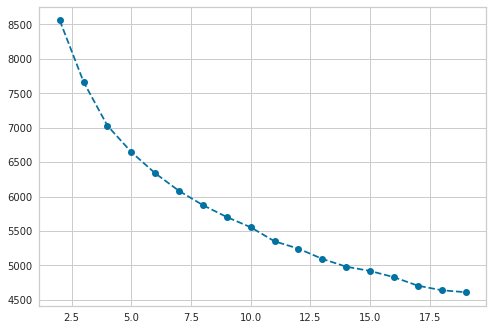

In [153]:
t = dict({'clusterCount': list(range(2,20)), 'cost_huang': cost_huang})
df = pd.DataFrame.from_dict(t)
plt.plot(df['clusterCount'], df['cost_huang'], linestyle='--', marker='o', color='b');

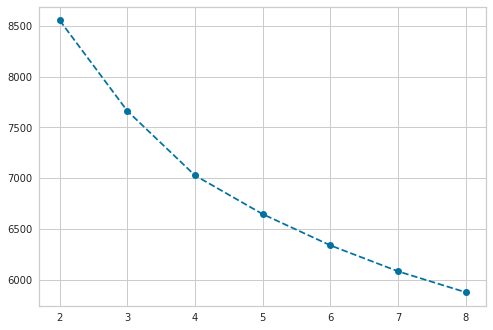

In [155]:
t = dict({'clusterCount': list(range(2,9)), 'cost_huang': cost_huang[0:7]})
df = pd.DataFrame.from_dict(t)
plt.plot(df['clusterCount'], df['cost_huang'], linestyle='--', marker='o', color='b');

In [156]:
clusterer = KPrototypes(n_jobs  = -1, n_clusters=5, init='Huang', verbose=2)
cluster_labels = clusterer.fit_predict(german_credit_clean,categorical=list(range(7,32)))

Best run was number 2


In [157]:
clusterer.cost_

6645.961704993757

In [158]:
clusterer = KPrototypes(n_jobs  = -1, n_clusters=4, init='Huang', verbose=2)
cluster_labels = clusterer.fit_predict(german_credit_clean,categorical=list(range(7,32)))
clusterer.cost_

Best run was number 5


7025.6008580998505

In [159]:
german_credit_clean['clusterLabel'] = clusterer.labels_

In [161]:
german_credit_clean.head(20)

,duration,amount,installment_rate,present_resid,age,n_credits,n_people,chk_acct_A11,chk_acct_A12,chk_acct_A13,...,property_A124,housing_A151,housing_A152,housing_A153,present_emp_A71,present_emp_A72,present_emp_A73,present_emp_A74,present_emp_A75,clusterLabel
0,-1.864869,-0.933901,0.918477,1.046987,2.271006,1.027079,-0.428290,1,0,0,...,0,0,1,0,0,0,0,0,1,3
1,1.708369,1.163046,-0.870183,-0.765977,-1.446152,-0.704926,-0.428290,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,-0.673790,-0.181559,-0.870183,0.140505,1.226696,-0.704926,2.334869,0,0,0,...,0,0,1,0,0,0,0,1,0,2
3,1.478913,1.525148,-0.870183,1.046987,0.942455,-0.704926,2.334869,1,0,0,...,0,0,0,1,0,0,0,1,0,2
4,0.517289,0.904743,0.024147,1.046987,1.488620,1.027079,2.334869,1,0,0,...,1,0,0,1,0,0,1,0,0,2
5,1.214026,1.703911,-0.870183,1.046987,0.103614,-0.704926,2.334869,0,0,0,...,1,0,0,1,0,0,1,0,0,2
6,0.517289,0.207588,0.024147,1.046987,1.488620,-0.704926,-0.428290,0,0,0,...,0,0,1,0,0,0,0,0,1,3
7,1.214026,1.362630,-0.870183,-0.765977,0.103614,-0.704926,-0.428290,0,1,0,...,0,1,0,0,0,0,1,0,0,0
8,-0.673790,0.305575,-0.870183,1.046987,1.957856,-0.704926,-0.428290,0,0,0,...,0,0,1,0,0,0,0,1,0,3
9,0.900731,0.997621,0.918477,-0.765977,-0.641198,1.027079,-0.428290,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [166]:
german_credit_clean2 = german_credit[['chk_acct','credit_his','sex','property','housing','present_emp']]
german_credit_clean2= pd.concat([german_credit_num_std, german_credit_clean2], axis = 1, join='inner')
german_credit_clean2.head()

,duration,amount,installment_rate,present_resid,age,n_credits,n_people,chk_acct,credit_his,sex,property,housing,present_emp
0,-1.864869,-0.933901,0.918477,1.046987,2.271006,1.027079,-0.428290,A11,A34,A93,A121,A152,A75
1,1.708369,1.163046,-0.870183,-0.765977,-1.446152,-0.704926,-0.428290,A12,A32,A92,A121,A152,A73
2,-0.673790,-0.181559,-0.870183,0.140505,1.226696,-0.704926,2.334869,A14,A34,A93,A121,A152,A74
3,1.478913,1.525148,-0.870183,1.046987,0.942455,-0.704926,2.334869,A11,A32,A93,A122,A153,A74
4,0.517289,0.904743,0.024147,1.046987,1.488620,1.027079,2.334869,A11,A33,A93,A124,A153,A73


In [171]:
%%time
cost_huang2=[]
for i in range(2,20):
    clusterer = KPrototypes(n_jobs=-1, n_clusters=i, init='Huang', verbose=2)
    cluster_labels = clusterer.fit_predict(german_credit_clean2,categorical=list(range(7,13)))
    cost_huang2.append(clusterer.cost_)

Best run was number 8
Best run was number 3
Best run was number 2
Best run was number 10
Best run was number 6
Best run was number 10
Best run was number 8
Best run was number 1
Best run was number 7
Best run was number 10
Best run was number 3
Best run was number 4
Best run was number 2
Best run was number 1
Best run was number 1
Best run was number 7
Best run was number 1
Best run was number 2
CPU times: user 5.2 s, sys: 35.4 ms, total: 5.24 s
Wall time: 3min 33s


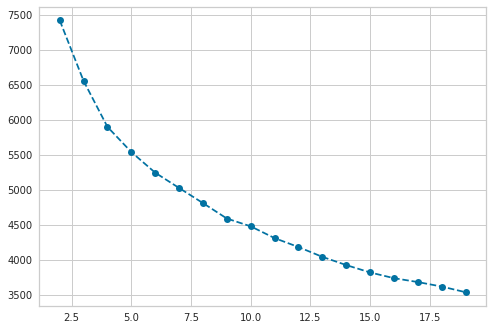

In [172]:
t = dict({'clusterCount': list(range(2,20)), 'cost_huang': cost_huang2})
df = pd.DataFrame.from_dict(t)
plt.plot(df['clusterCount'], df['cost_huang'], linestyle='--', marker='o', color='b');

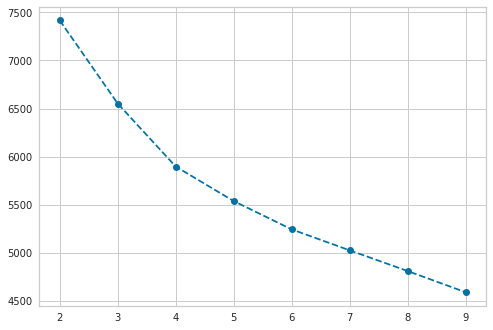

In [173]:
t = dict({'clusterCount': list(range(2,10)), 'cost_huang': cost_huang2[0:8]})
df = pd.DataFrame.from_dict(t)
plt.plot(df['clusterCount'], df['cost_huang'], linestyle='--', marker='o', color='b');

In [255]:
# let's try cluster of 5
clusterer = KPrototypes(n_jobs=-1, n_clusters=4, init='Huang', verbose=2)
cluster_labels = clusterer.fit_predict(german_credit_clean2,categorical=list(range(7,13)))
german_credit_clean2['costLabel'] = clusterer.labels_

Best run was number 2


In [256]:
german_credit_clean2.head()

,duration,amount,installment_rate,present_resid,age,n_credits,n_people,chk_acct,credit_his,sex,property,housing,present_emp,costLabel
0,-1.864869,-0.933901,0.918477,1.046987,2.271006,1.027079,-0.428290,A11,A34,A93,A121,A152,A75,2
1,1.708369,1.163046,-0.870183,-0.765977,-1.446152,-0.704926,-0.428290,A12,A32,A92,A121,A152,A73,3
2,-0.673790,-0.181559,-0.870183,0.140505,1.226696,-0.704926,2.334869,A14,A34,A93,A121,A152,A74,1
3,1.478913,1.525148,-0.870183,1.046987,0.942455,-0.704926,2.334869,A11,A32,A93,A122,A153,A74,1
4,0.517289,0.904743,0.024147,1.046987,1.488620,1.027079,2.334869,A11,A33,A93,A124,A153,A73,1


In [257]:
german_credit['costLabel'] = clusterer.labels_

In [258]:
german_credit[(german_credit['costLabel']==2) & (german_credit['response']==2) ].count()

chk_acct            41
duration            41
credit_his          41
purpose             41
amount              41
saving_acct         41
present_emp         41
installment_rate    41
sex                 41
oethre_debtor       41
present_resid       41
property            41
age                 41
other_install       41
housing             41
n_credits           41
job                 41
n_people            41
telephone           41
foreign             41
response            41
costLabel           41
dtype: int64

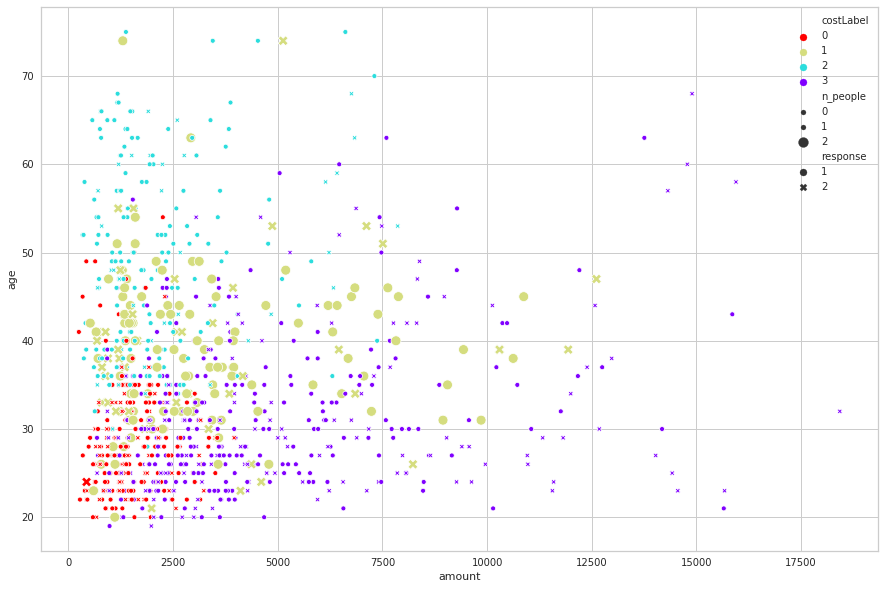

In [283]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=german_credit, x='amount', y='age', hue='costLabel', palette="rainbow_r", \
                style='response', size="n_people");